In [1]:
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union

In [2]:
cad_df = gpd.read_file("Files/cadastre.gpkg")
gnaf_df = pd.read_parquet("Files/gnaf_prop.parquet")
roads_df = gpd.read_file("Files/roads.gpkg")
tran_df = pd.read_parquet("Files/transactions.parquet")

In [3]:
gnaf_df['full_address'] = (
    gnaf_df['flat_number'].fillna('') + ' ' +
    gnaf_df['level_number'].fillna('') + ' ' +
    gnaf_df['building_name'].fillna('') + ' ' +
    gnaf_df['lot_number'].fillna('') + ' ' +
    gnaf_df['number_first'].fillna('') + 
    gnaf_df['number_last'].fillna('').apply(lambda x: '-' + x if x else '') + ' ' +
    gnaf_df['street_name'].fillna('') + ' ' +
    gnaf_df['street_type'].fillna('') + ' ' +
    gnaf_df['street_suffix'].fillna('') + ', ' +
    gnaf_df['locality_name'].fillna('') + ' ' +
    gnaf_df['postcode'].fillna('') + ', ' +
    gnaf_df['state'].fillna('')
)
gnaf_df['full_address'] = gnaf_df['full_address'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [4]:
def polygon_orientation_safe(geom):
    if geom is None:
        return None
    # Handle MultiPolygons
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda a: a.area)
    if not isinstance(geom, Polygon):
        return None
    coords = list(geom.exterior.coords)
    if len(coords) < 2:
        return None
    p1, p2 = coords[0], coords[1]
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = math.degrees(math.atan2(dx, dy))
    if angle < 0:
        angle += 360
    directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    idx = int((angle + 22.5) // 45) % 8
    return directions[idx]

# Apply orientation to cadastral polygons
cad_df['orientation'] = cad_df['geometry'].apply(polygon_orientation_safe)

In [5]:
gnaf_points = gpd.GeoDataFrame(
    gnaf_df,
    geometry=gpd.points_from_xy(gnaf_df['longitude'], gnaf_df['latitude']),
    crs='EPSG:4326'
)

In [6]:
# Spatial join with buffer to reduce NaNs
gnaf_points['orientation'] = None  # initialize column
for idx, prop in gnaf_points.iterrows():
    # create small buffer around point
    point_buffer = prop.geometry.buffer(0.0005)  # ~10m buffer
    match = cad_df[cad_df.intersects(point_buffer)]
    if not match.empty:
        gnaf_points.at[idx, 'orientation'] = match.iloc[0]['orientation']


In [7]:
output_cols = ['full_address', 'orientation']


In [8]:
gnaf_points[output_cols].to_csv("property_orientation.csv", index=False)
print("Saved property_orientation.csv")

Saved property_orientation.csv


In [9]:
print(gnaf_points[output_cols].head())

                                  full_address orientation
0   1 10 MELNOTTE AVENUE , ROSEVILLE 2069, NSW        None
1  26 11 MELNOTTE AVENUE , ROSEVILLE 2069, NSW          SW
2  16 12 MELNOTTE AVENUE , ROSEVILLE 2069, NSW        None
3  27 13 MELNOTTE AVENUE , ROSEVILLE 2069, NSW        None
4   1 14 MELNOTTE AVENUE , ROSEVILLE 2069, NSW        None


In [10]:
total_rows = len(gnaf_points)
none_count = gnaf_points['orientation'].isna().sum()  # counts None/NaN
not_none_count = total_rows - none_count

print(f"Total rows: {total_rows}")
print(f"Rows with orientation (not None): {not_none_count}")
print(f"Rows missing orientation (None/NaN): {none_count}")

Total rows: 70591
Rows with orientation (not None): 18708
Rows missing orientation (None/NaN): 51883


In [11]:
gnaf_points['orientation'].value_counts()

orientation
SW    4362
W     4305
S     2926
SE    2746
E     2372
N      922
NE     727
NW     348
Name: count, dtype: int64

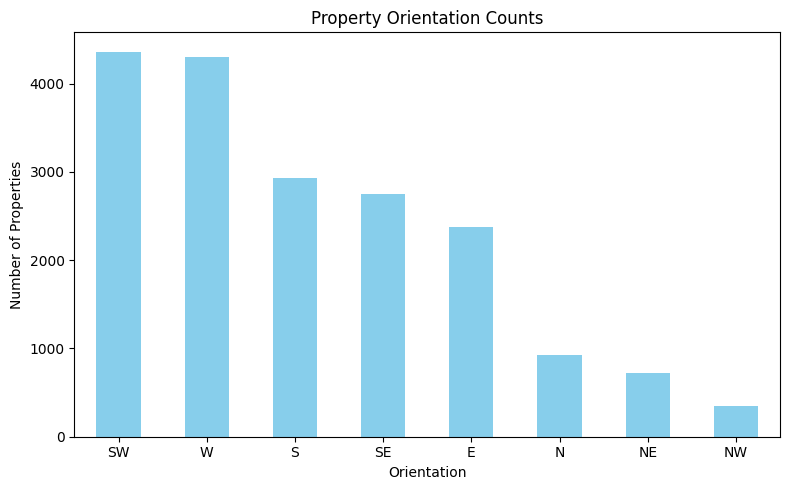

In [14]:
import matplotlib.pyplot as plt

counts = gnaf_points['orientation'].value_counts()

plt.figure(figsize=(8,5))
counts.plot(kind='bar', color='skyblue')
plt.title("Property Orientation Counts")
plt.xlabel("Orientation")
plt.ylabel("Number of Properties")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()